In [1]:
!pip install tabulate

import pm4py
import pandas as pd
import networkx as nx

from typing import List
from StateMachine import StateMachine

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

def to_graph(SM):
    SM_disc = nx.DiGraph()
    for state in SM['_StateMachine__states']:
        SM_disc.add_node(state['_state__name'], replicas = state['_state__Resourcerequirements']['replicas'], type=state['_state__type'])
    for transition in SM['_StateMachine__transitions']:
        SM_disc.add_edge(transition['_transition__source'], transition['_transition__target'], 
                        name=transition['_transition__name'], events=transition['_transition__events'], actions=transition['_transition__actions'])
    return SM_disc

def plot(SM):
    labels = {}
    pos = {}
    row = 0
    col = 0
    max_col = 2
    
    for idx, att in enumerate(SM.nodes(data=True)):
        labels[att[0]] = f" {att[0]}  \n {att[1]['type']} \n Replicas: {att[1]['replicas']}"
        if col >= max_col:
            row += 1
            col = 0
        pos[att[0]] = (col , -row)
        col += 1
    
    edge_labels = {}
    for att in SM.edges(data=True):
        edge_labels[(att[0],att[1])] = f"{att[2]['name']}, \n {att[2]['events'][0]['_event__id']}, {att[2]['events'][0]['_event__type']}, {att[2]['events'][0]['_event__predicate']['metric']}, {att[2]['events'][0]['_event__predicate']['operator']}, {att[2]['events'][0]['_event__predicate']['refValue']}%, {att[2]['events'][0]['_event__predicate']['time']} \n {att[2]['actions'][0]['_action__id']} {att[2]['actions'][0]['_action__type']} {att[2]['actions'][0]['_action__attributes']}  "
    fig, ax = plt.subplots()
    nx.draw(SM, pos=pos, labels=labels, node_size=8000, ax=ax)
    #nx.draw_networkx_nodes(SM, pos, node_size=5000, node_labels=labels, node_color='skyblue', node_shape='s', alpha=0.8)
    nx.draw_networkx_edge_labels(SM, edge_labels=edge_labels, pos=pos, font_size=12, ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    fig.set_size_inches(10, 8)
    
    #plt.autoscale()
    plt.tight_layout(pad=2.5)
    plt.show()



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# CC4MCSLAEnriched

The notebook describes our approach to state machine abstraction and compliance checking using the alignment technique. The approach requires an event log and a defined state machine as inputs, and consists of three components: annotation, abstraction, and checker.

The first component, the annotation component, is responsible for annotating the events contained in an event log based on a knowledge base. This annotation process identifies whether an event is related to a state or a transition in order to abstract a state machine discovered in the next component.

The second component, the abstraction component, is responsible for discovering a state machine in the event log. This component uses the annotated event log to identify the states and transitions in the log and to construct a state machine model on the basis of patterns.

The last component, the checker, compares the discovered state machine with the defined state machine to identify deviations between what happened and what is defined. This component checks for compliance between the defined state machine and the actual behavior captured in the event log.

Overall, the approach presented in this notebook provides a way to automatically abstract state machines from event logs and to check their compliance with a defined state machine. 

## Annotation ##

The first component use an ontology for describing the Knowledge Base and annotate the events composing the event log. We use python and the library owlready2 to implement and read ontology. 

In [2]:
from owlready2 import * 
onto = get_ontology('http://test.org/onto.owl')

##### Ontology Classes Definition ##### 
with onto: 
    class stateMachine(Thing):
        pass
    class State(stateMachine):
        pass
    class Start(State):
        pass
    class Execute(State):
        pass
    class Complete(State):
        pass
    class Transition(stateMachine):
        pass
    class eventType(Thing):
        pass
    class isRelatedTo(ObjectProperty, FunctionalProperty):
        domain = [eventType]
        range  = [stateMachine]

##### Declare event types ##### Individuals
Service_Create = eventType('Service_Create', isRelatedTo=Start)
Service_Remove = eventType('Service_Remove', isRelatedTo=Start)
Service_Update = eventType('Service_Update', isRelatedTo=Start)
Container_Create = eventType('Container_Create', isRelatedTo=Execute)
Container_Destroy = eventType('Container_Destroy', isRelatedTo=Execute)
Container_Start = eventType('Container_Start', isRelatedTo=Complete)
Container_Stop = eventType('Container_Stop', isRelatedTo=Complete)
Ressource_Usage = eventType('Ressource_Usage', isRelatedTo=Transition)

onto.save(file='onto.owl', format="rdfxml")


* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [3]:
print(list(onto.classes()))
print(list(onto.individuals()))
print(list(onto.object_properties()))

[onto.stateMachine, onto.State, onto.Start, onto.Execute, onto.Complete, onto.Transition, onto.eventType]
[onto.Service_Create, onto.Service_Remove, onto.Service_Update, onto.Container_Create, onto.Container_Destroy, onto.Container_Start, onto.Container_Stop, onto.Ressource_Usage]
[onto.isRelatedTo]


We then define a function to find the ancestors in an ontology of the type of event identified in the event logs.

In [4]:
##### Ancestors Calling #####
def search_ancestors(onto, ask):
    result = onto.search(iri = "*{}".format(ask))
    lcStep = str(result[0].isRelatedTo).split('.')[1]
    smElt = str(result[0].isRelatedTo.is_a[0]).split('.')[1]
    if lcStep == 'Transition':
        smElt = 'Transition'
        lcStep = 'N/A'
    return [smElt, lcStep]

The annotation function of the event-logs is implemented in the final stage, whereby the state-machine element and lifecycle step are incorporated into each event. The function outputs an XES file containing the annotated events with the additional metadata.

In [5]:
#### Pre-processing based on ontology ####
import pandas as pd
import pm4py

#### Import event-logs from CSV to pandas dataframe
dataframe = pd.read_csv('Datasets/DockerSwarm_logs.csv', sep=',')
pd.set_option('display.width',1000)
dataframe = pm4py.format_dataframe(dataframe, case_id='Resource Name', activity_key='Event-Type', timestamp_key='Timestamp')

### Print Raw event logs
print("Raw event-logs")
print(dataframe[['Timestamp', 'Source', 'Resource Name', 'Event-Type', 'Metric', 'Value']])

Raw event-logs
                   Timestamp     Source Resource Name         Event-Type     Metric Value
0  2023-07-05 00:00:03+00:00   Provider          Auth     Service_Create   replicas     2
1  2023-07-05 00:00:04+00:00   Provider          Auth   Container_Create          /     /
2  2023-07-05 00:00:05+00:00   Provider          Auth    Container_Start          /     /
3  2023-07-05 00:00:05+00:00  Ressource          Auth    Ressource_Usage  Cpu Usage    15
4  2023-07-05 00:01:05+00:00  Ressource          Auth    Ressource_Usage  Cpu Usage    15
..                       ...        ...           ...                ...        ...   ...
73 2023-07-05 00:03:05+00:00  Ressource            UI    Ressource_Usage  Cpu Usage    15
74 2023-07-05 00:03:15+00:00  Ressource            UI    Ressource_Usage  Cpu Usage    15
75 2023-07-05 00:03:45+00:00   Provider            UI     Service_Update   replicas     0
76 2023-07-05 00:03:46+00:00   Provider            UI  Container_Destroy          /  

In [6]:
#### Iterate through event logs ####
for idx, row in dataframe.iterrows():
    # Search event type in ontology and returns ancestors 
    smElt, lcStep = search_ancestors(onto, row['Event-Type'])
    dataframe.loc[[idx],'smElt'] = smElt
    dataframe.loc[[idx],'lcStep'] = lcStep

### Export as XES ###
event_log = pm4py.convert_to_event_log(dataframe)
xes = pm4py.write_xes(event_log, 'exported.xes')

### Print Dataframe
print("Annotated logs with state-machine element (smElt) and lifecycle step (lcStep)")
print(dataframe[['Timestamp', 'Source', 'Resource Name', 'Event-Type', 'Metric', 'Value', 'smElt', 'lcStep']])


exporting log, completed traces :: 100%|██████████| 3/3 [00:00<00:00, 333.48it/s]

Annotated logs with state-machine element (smElt) and lifecycle step (lcStep)
                   Timestamp     Source Resource Name         Event-Type     Metric Value       smElt    lcStep
0  2023-07-05 00:00:03+00:00   Provider          Auth     Service_Create   replicas     2       State     Start
1  2023-07-05 00:00:04+00:00   Provider          Auth   Container_Create          /     /       State   Execute
2  2023-07-05 00:00:05+00:00   Provider          Auth    Container_Start          /     /       State  Complete
3  2023-07-05 00:00:05+00:00  Ressource          Auth    Ressource_Usage  Cpu Usage    15  Transition       N/A
4  2023-07-05 00:01:05+00:00  Ressource          Auth    Ressource_Usage  Cpu Usage    15  Transition       N/A
..                       ...        ...           ...                ...        ...   ...         ...       ...
73 2023-07-05 00:03:05+00:00  Ressource            UI    Ressource_Usage  Cpu Usage    15  Transition       N/A
74 2023-07-05 00:03:15+00:

Therefore, the annotation component generates an annotated XES file that includes state-machine elements (smElt) and lifecycle steps (lcStep). This file is then utilized by the subsequent component responsible for state-machine abstraction.

### Abstraction

Based on the XES annotated event logs, we abstract state-machine using our defined patterns. We define several functions in order to identify state-machine elements. We also define an abstract function for pattern identification of events in a pandas dataframe rows. 

The pattern_identification function allows to define an event pattern, to identify the corresponding events in the log and to return the index.

In [7]:
#### Function Definition ####
def pattern_identification(log: pd.DataFrame, pattern: List, attribute: str):
    """ 
        Return index of pattern in log in DataFrame 
    """
    # Identify number of item in pattern
    nbPattern = len(pattern)

    # Construction pattern as string
    ## Begin of request
    pattern_s = f"""log.index[(log['{attribute}'] == '{pattern[0]}')"""
    for item in range(1, nbPattern):
        pattern_s += f""" & (log['{attribute}'].shift(-{item}) == '{pattern[item]}')"""
    ## End of request
    pattern_s += f"""]"""

    # Execution of defined pattern
    indice_p_s = eval(pattern_s)
    return indice_p_s


The state_abstraction function defines the pattern (Pattern 3.1 of the paper) of three events following with 'Start', 'Execute' and 'Complete' in the lcStep column such as : 

| Timestamp | ... | srcname | Metrics                               | lcStep    | smElt |
| ---       | --- | ---     |                   ---                 | ---       | ---   |
| 00:03     | ... | UI      | [replicas.new = 8,replicas.old = 0]   | Start     | State |
| 00:04     | ... | UI      |               /                       | Execute   | State |
| 01:01     | ... | UI      |               /                       | Execute   | State |
| 01:02     | ... | UI      |               /                       | Complete  | State |

Then, the state_type_abstraction function (Pattern 3.2 of the paper) identify the type state type of discovered state. 


In [8]:
def state_abstraction(log: pd.DataFrame, SM_name):
    """
        Return states identified
    """
    ## Declare discovered state machine
    SM_Discovered = StateMachine(
        name=SM_name
    )

    pattern=['Start', 'Execute', 'Complete']

    states_index = pattern_identification(log, pattern, 'lcStep')
    states_name = []

    print(states_index)

    for i, s in enumerate(states_index, 1):

        S_name = 'S'+str(i)
        states_name.append(S_name)
        SM_Discovered.add_state(StateMachine.state(
            name= S_name,
            type='',
            Resourcerequirements={
                log.loc[s]['Metric'] : log.loc[s]['Value']
            },
            occurence=1
        ))
    return SM_Discovered, states_index, states_name

def state_type_abstraction(log: pd.DataFrame, State_Machine_Discovered: StateMachine):
    """
        Apply State-Type Abstraction
    """
    state_nb = len(State_Machine_Discovered.states)
    for state in State_Machine_Discovered.states:
        if state.name == 'S1':
            state.set_type('isInitial')
        elif int(state.name[1:]) < state_nb:
            state.set_type('isNormal')
        elif int(state.name[1:]) == state_nb:
            state.set_type('isFinal')
    return State_Machine_Discovered


The transition_abstraction function defines a pattern for identifying transtions in the state-machine (Pattern 3.3 and 3.4 of the paper) 

In [9]:
def transition_abstraction(log: pd.DataFrame, State_Machine_Discovered: StateMachine, states_index):
    """
        Abstraction transition by combining reconfiguration actions and triggering event associated to the state-machine
    """
    states = State_Machine_Discovered.states
    for idx, state in enumerate(states):
        if idx < (len(states) - 1):
            diff_state = int(states[idx+1].Resourcerequirements['replicas']) - int(states[idx].Resourcerequirements['replicas'])

            if diff_state > 0:
                type = 'Scale-out'
            elif diff_state < 0:
                type = 'Scale-in'
            else:
                type = 'Error'
                print('Error: State Equivalent')

            #### Get states Event
            # Set time window selected
            time_window = timedelta(minutes=1)

            # Select events in the time window before state execution
            pattern_ts = log.loc[states_index[idx+1]]['time:timestamp']
            pattern_ts_minus_tw = (pattern_ts - time_window).isoformat()
            transition_Window = log[ ( log['time:timestamp'] > pattern_ts_minus_tw) & \
                (log['time:timestamp'] < pattern_ts) & (log['smElt'] == 'Transition' )].astype({'Value': int})
            
            # Return for each metric observed a consumption average
            avg = transition_Window.groupby('Metric')['Value'].mean().round(2).to_dict()

            if bool(avg) != False:
                State_Machine_Discovered.add_transition(
                    StateMachine.transition(
                        name=f"T{idx+1}",
                        source=state.name,
                        target=states[idx+1].name,
                        events=[StateMachine.event(
                                    id = 'E1',
                                    type = 'ResourceRelatedEvent',
                                    predicate = {
                                        'metric': 'Cpu Usage',
                                        'operator': '>=',
                                        'refValue': avg['Cpu Usage'],
                                        'time': str(time_window.total_seconds()) + 's'
                                    })],
                        actions=[StateMachine.action(
                            id = 'A1',
                            type = type,
                            attributes= {
                                'replicas' : abs(diff_state)
                            }
                        )]
                ))

    return State_Machine_Discovered

#### Execution of Abstraction 

Using these defined abstraction pattern, we identified state-machine from the event-logs. Then, we show the identified state-machine. 


In [10]:
##### Importation of annotated event logs #####
file_path = 'exported.xes'
event_log = pm4py.read_xes(file_path)

SMs_Discovered = []
# Filter by case
events = event_log.groupby('@@case_index')
for i, case_event_log in events:
    ##### Get Ressource Name
    ResName = case_event_log['Resource Name'].iloc[1]
    print(ResName)
    print(case_event_log)
 
    ##### State abstraction : Pattern 3.1 #####
    SM_Discovered, states_index, states_name = state_abstraction(case_event_log, ResName)

    ##### State-Type abstraction : Pattern 3.2 #####
    SM_Discovered = state_type_abstraction(case_event_log, SM_Discovered)

    ##### Transition abstraction : Pattern 3.3 + 3.4 #####
    SM_Discovered = transition_abstraction(case_event_log, SM_Discovered, states_index)
    json = SM_Discovered.to_json()

    with open(f"SM_discovered/SM_{SM_Discovered.name}.json", "w") as outfile:
        outfile.write(json)

    SMs_Discovered.append(SM_Discovered)

print("Discovered State-Machine")
for SM in SMs_Discovered: print(SM)

parsing log, completed traces :: 100%|██████████| 3/3 [00:00<00:00, 249.64it/s]

Auth
                   Timestamp     Source Resource Name         Event-Type     Metric Value       concept:name            time:timestamp  @@index  @@case_index       smElt    lcStep case:concept:name
0  2023-07-05 00:00:03+00:00   Provider          Auth     Service_Create   replicas     2     Service_Create 2023-07-05 00:00:03+00:00        0             0       State     Start              Auth
1  2023-07-05 00:00:04+00:00   Provider          Auth   Container_Create          /     /   Container_Create 2023-07-05 00:00:04+00:00        1             0       State   Execute              Auth
2  2023-07-05 00:00:05+00:00   Provider          Auth    Container_Start          /     /    Container_Start 2023-07-05 00:00:05+00:00        2             0       State  Complete              Auth
3  2023-07-05 00:00:05+00:00  Ressource          Auth    Ressource_Usage  Cpu Usage    15    Ressource_Usage 2023-07-05 00:00:05+00:00        3             0  Transition       N/A              Auth
4  20

With the discovered state-machine in hand, it is now possible to apply conformance checking with the defined state-machine. 

### Alignment

The final section of this study focuses on the implementation of an alignment algorithm that is used to identify any deviations between the defined state-machine and the observed state-machine. 

### Defined state-machine ###


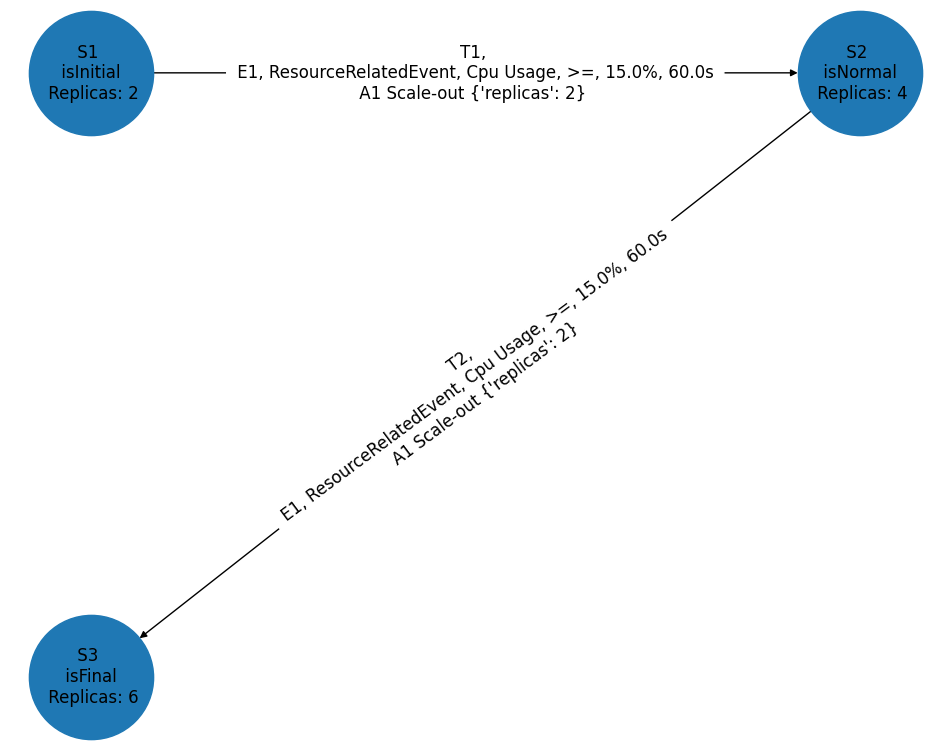

### Discovered state-machines ###


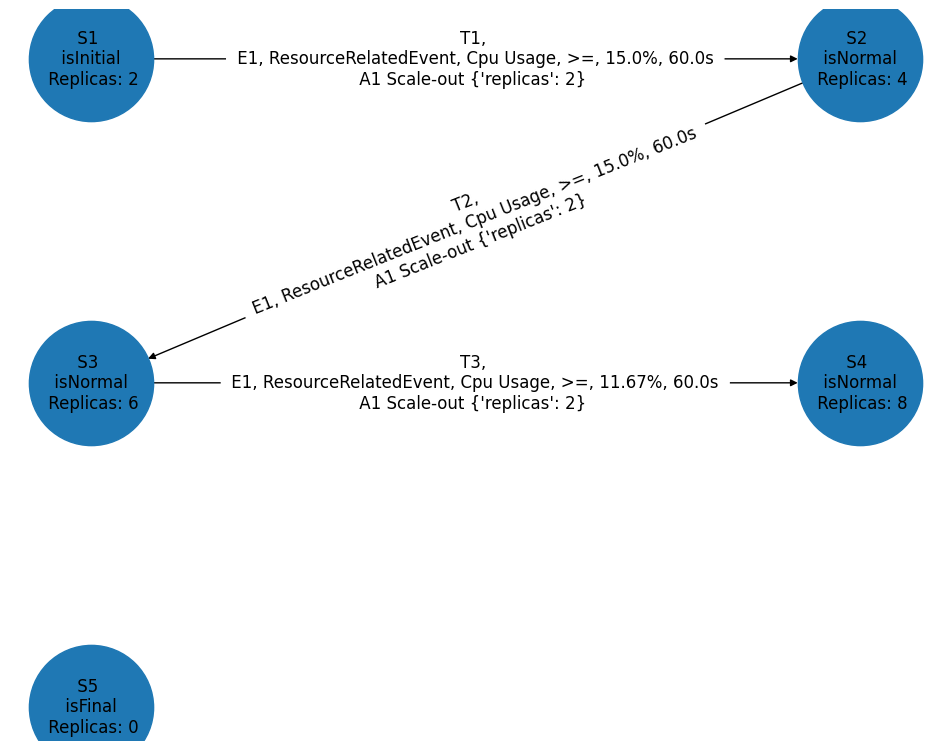

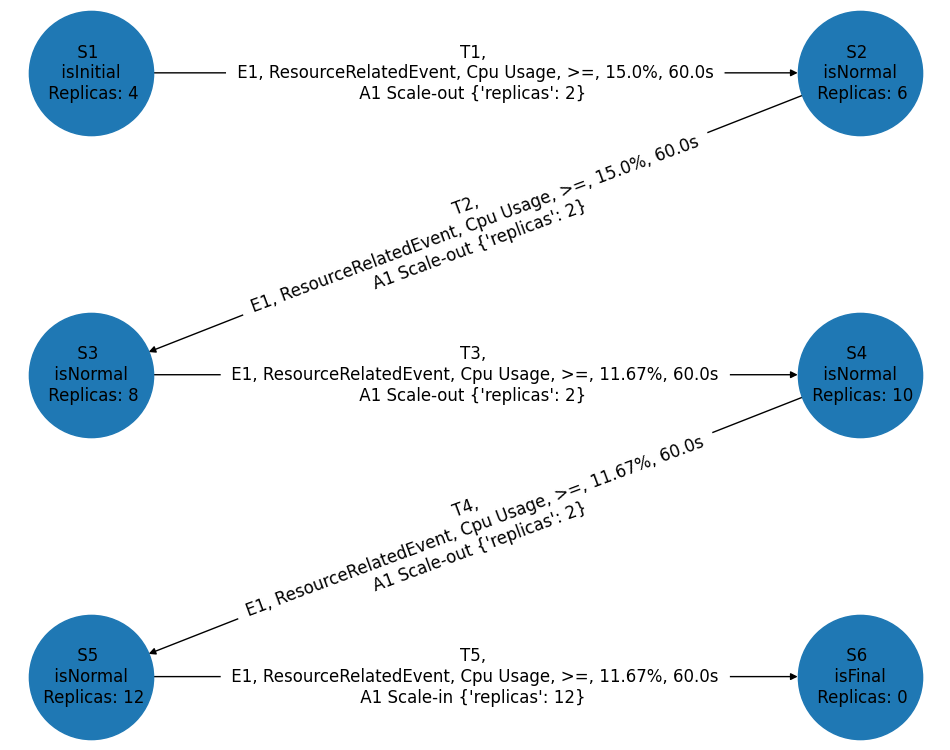

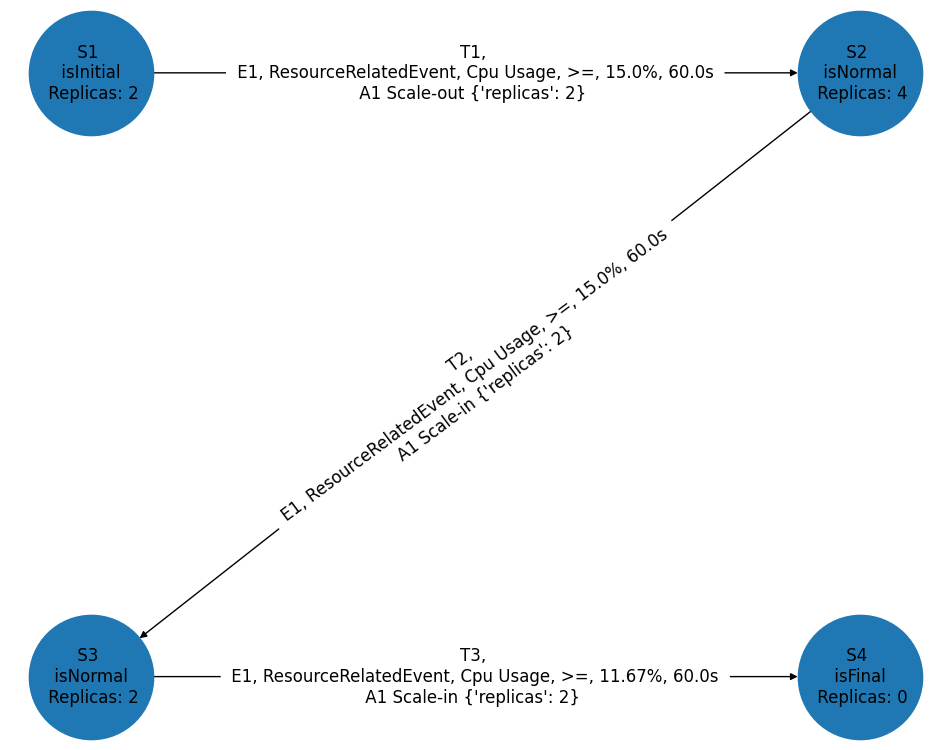

In [11]:
""" 
    Checker 
""" 
import matplotlib.pyplot as plt
import json
import networkx as nx

import glob

def get_initial_nodes(graph):
    return [n for n,d in graph.in_degree() if d==0]

def get_final_nodes(graph):
    return [n for n,d in graph.out_degree() if d==0]

SMs_Disc = []
### Discovered state-machine
for filename in glob.iglob(f'SM_Discovered/*'):
    SMs_Disc.append(to_graph(json.load(open(filename))))

### Defined state-machine
SM_Def = to_graph(json.load(open("SM_Defined.json")))

print("### Defined state-machine ###")
plot(SM_Def)

print("### Discovered state-machines ###")
for SM_Disc in SMs_Disc:
    plot(SM_Disc)


#### Search Space Construction

The alignment technique is used to identify deviations by attempting to align the defined state-machine and the discovered state-machine. The process of searching for the optimal alignment is carried out in two steps: first, constructing a search space that represents all possible moves; and second, searching for the optimal path within this search space. 

In [12]:
def search_space_construction(SM_Disc, SM_Def):
    """
        Construct Search space of Alignment
    """
    ### Search Space construction
    SS = nx.DiGraph()
    SS.add_node(0, weight=0)

    for i, (eltx, elty) in enumerate(zip(SM_Disc.nodes, SM_Def.nodes)):
        temp_last_nodes = get_final_nodes(SS)
        # e = epsilon to guarantee algorithm end
        e = i*0.1
        if SM_Disc.nodes[eltx]['replicas'] == SM_Def.nodes[elty]['replicas']:
            # State equivalent 
            SS.add_node(str([eltx,elty]), weight=1+e)
            [SS.add_edge(node, str([eltx,elty])) for node in temp_last_nodes]
        else:
            SS.add_node(str([eltx,'>>']), weight=5+e)
            SS.add_node(str(['>>',elty]), weight=5+e)
            [SS.add_edge(node, str([eltx,'>>'])) for node in temp_last_nodes]
            [SS.add_edge(node, str(['>>',elty])) for node in temp_last_nodes]

        temp_last_nodes = get_final_nodes(SS)
        # If the state is not final 
        if SM_Disc.out_edges(eltx, data=True) and SM_Def.out_edges(elty, data=True):
            T_disc_tmp = {
                'name' : list(SM_Disc.out_edges(eltx, data=True))[0][2]['name'],
                'events' : list(SM_Disc.out_edges(eltx, data=True))[0][2]['events'],
                'actions' : list(SM_Disc.out_edges(eltx, data=True))[0][2]['actions']
            }
            
            T_def_tmp = {
                'name' : list(SM_Def.out_edges(elty, data=True))[0][2]['name'],
                'events' : list(SM_Def.out_edges(elty, data=True))[0][2]['events'],
                'actions' : list(SM_Def.out_edges(elty, data=True))[0][2]['actions']
            }

            # Check if event is equivalent
            if (T_disc_tmp['events'][0]['_event__predicate'] == T_def_tmp['events'][0]['_event__predicate']) and (T_disc_tmp['actions'][0] == T_def_tmp['actions'][0]):
                SS.add_node(str([T_disc_tmp['name'],T_def_tmp['name']]), weight=1+e)
                [SS.add_edge(node, str([T_disc_tmp['name'],T_def_tmp['name']])) for node in temp_last_nodes]
            else:
                SS.add_node(str([T_disc_tmp['name'],'>>']), weight=5+e)
                SS.add_node(str(['>>',T_def_tmp['name']]), weight=5+e)
                [SS.add_edge(node, str([T_disc_tmp['name'],'>>'])) for node in temp_last_nodes]
                [SS.add_edge(node, str(['>>',T_def_tmp['name']])) for node in temp_last_nodes]
    return SS

print("Construction of Search Space ... ")
SSs = []
for SM_Disc in SMs_Disc:
    SS = search_space_construction(SM_Disc, SM_Def)
    SSs.append(SS)

print("Search Spaces constructed")

Construction of Search Space ... 
Search Spaces constructed


In this final step, we search in the previously constructed search space a optimal path and compute the fitness value.

In [13]:
# format table 
from tabulate import tabulate 

for SS in SSs: 
    ### Identify starting and ending nodes of the search space 
    starting_nodes = get_initial_nodes(SS) 
    ending_nodes = get_final_nodes(SS) 

    ### Compute the worst possible alignment 
    y_worst_sum = ((len(SM_Def.nodes) * 2 ) * 5) 

    ### Compute the cost of an identified alignment 
    results_path = [] 
    for s in starting_nodes: 
        for e in ending_nodes: 
            y_optimal_cost = 0 
            path = nx.astar_path(SS, s, e) 

            for elt in path: y_optimal_cost+=SS.nodes[elt]['weight'] 
            results_path.append((path, y_optimal_cost)) 
            fitnessValue = round(1 - y_optimal_cost / y_worst_sum, 2) 

    print("Report : ")
    alignment = [eval(item) for item in results_path[0][0][1:]]
    print(f"Alignment :\n {tabulate(alignment, headers=['Defined', 'Discovered'])}")
    print(f"Y_Optimal : {y_optimal_cost} ")
    print(f"FitnessValue : {fitnessValue} \n")


Report : 
Alignment :
 Defined    Discovered
---------  ------------
S1         S1
T1         T1
S2         S2
T2         T2
S3         S3
Y_Optimal : 5.4 
FitnessValue : 0.82 

Report : 
Alignment :
 Defined    Discovered
---------  ------------
S1         >>
T1         T1
S2         >>
T2         T2
S3         >>
Y_Optimal : 17.4 
FitnessValue : 0.42 

Report : 
Alignment :
 Defined    Discovered
---------  ------------
S1         S1
T1         T1
S2         S2
T2         >>
S3         >>
Y_Optimal : 13.399999999999999 
FitnessValue : 0.55 

